# Table of Contents
---

### 1. [**Goal of this Lab**](#section:goal)

### 2. [**Preliminaries**](#section:preliminaries)

### 3. [**Part 1: Fine-tune Idefics2 on custom dataset**](#section:part1)

### 3. [**Part 2: Multimodal Text Generation with Pretrained Visual Language Models**](#section:part2)

### 4. [**Part 3: Visual Language Models as Judges for Free-form Text Generation**](#section:part3)

### 5. [**Part 4: Assessing The Ratings of The Judge Model**](#section:part4)

### 6. [**Conclusion**](#section:conclusion)

### 7. [**Acknowledgements**](#section:acknowledgements)



<a name="section:goal"></a>
# Goal of this Lab


**<ins>What we are going to do in the lab</ins>**


Our goal in this lab is to provide the basic blocks of fine-tuning and evaluating multimodal models. The lab is divided into four parts:


* Part 1 includes a minimal example of how to finetune a pretrained model ([Idefics2](https://arxiv.org/pdf/2405.02246)) on a custom dataset. Here we focus on the task of document understanding, where the model is given an image of a document, a question, and needs to provide the correct answer.
* Part 2 includes an inference example using the successor of Idefics2 on more open-ended multimodal tasks. More specifically, the model accepts any images and prompts (questions) and needs to provide a response that is appropriate to the prompt. We also explore different generation hyperparameters and observe their impact on the generated output.
* Part 3 introduces a way to evaluate free-form generation of multimodal chat models, where a different (or the same) model acts as a judge that ranks the generated output based on exemplary responses
* Part 4 further adds to part 3. In the final part of this lab, you will be asked to review a few predictions, provide a score, and see how your judgement correlates with the ratings provided from the judge model.




**<ins>What we are not going to do in the lab</ins>**


Similar to Lab 4, we are not going to build the next GPT4-V or anything close to it. The code below is designed purely for educational purposes so that you can customize it for your own future use case.

<a name="section:preliminaries"></a>
# Prelimaries

Lets install dependencies here

In [ ]:
!pip install -q accelerate datasets peft bitsandbytes
!pip install Levenshtein

<a name="section:part1"></a>
# Part 1: Fine-tune Idefics2 on custom dataset

## Loading the model and the dataset

We load the model from the Hugging Face hub. [Idefics2-8b](https://huggingface.co/HuggingFaceM4/idefics2-8b) has gone through [instruction fine-tuning](https://arxiv.org/pdf/2109.01652) on a large mixture of multimodal datasets and as such is a strong starting-point to fine-tune on your own use-case. We will start from this checkpoint.

In this tutorial, we will fine-tune (and evaluate) on the task of Document Visual Question Answering using a subset of the [DocVQA](https://www.docvqa.org/) dataset.

We follow a set of hyperparameters that enable training on a constrained in terms of computational resources (GPUs) environment:

* Using 4 bit quantization
* Lora fine-tuning
* Freezing the vision encoder
* Small batch size compensated with higher gradient accumulation degree

In [ ]:
import torch
from peft import LoraConfig
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics2ForConditionalGeneration

DEVICE = "cuda:0"
USE_LORA = False
USE_QLORA = True


processor = AutoProcessor.from_pretrained(
    "HuggingFaceM4/idefics2-8b",
    do_image_splitting=False
)


# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules='.*(text_model|modality_projection|perceiver_resampler).*(down_proj|gate_proj|up_proj|k_proj|q_proj|v_proj|o_proj).*$',
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        quantization_config=bnb_config if USE_QLORA else None,
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
else:
    model = Idefics2ForConditionalGeneration.from_pretrained(
        "HuggingFaceM4/idefics2-8b",
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2", # Only available on A100 or H100
    ).to(DEVICE)

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("nielsr/docvqa_1200_examples", split="train[:200]")
train_dataset = train_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

eval_dataset = load_dataset("nielsr/docvqa_1200_examples", split="test")
eval_dataset = eval_dataset.remove_columns(['id', 'words', 'bounding_boxes', 'answer'])

Let's look at an example. Each sample has an image of a document, a question (in multiple languages, although we'll use the English portion only), and a list of answers.

In [ ]:
train_dataset[10]

In [ ]:
train_dataset[10]["image"]

## Training Loop



We first define the data collator which takes list of samples and return input tensors fed to the model. There are 4 tensors types we are interested:

* input_ids: these are the input indices fed to the language model
attention_mask: the attention mask for the input_ids in the language model
* pixel_values: the (pre-processed) pixel values that encode the image(s). Idefics2 treats images in their native resolution (up to 980) and their native aspect ratio
* pixel_attention_mask: when multiple image(s) are packed into the same sample (or in the batch), attention masks for the images are necessary because of these images can have different sizes and aspect ratio. This masking ensures that the vision encoder properly forwards the images.

In [ ]:
import random
from typing import Any

class MyDataCollator:
    """Collator."""

    def __init__(self, processor) -> None:
        self.processor = processor
        self.image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]

    def __call__(self, examples: list[dict[str, Any]]) -> dict[str, torch.Tensor]:
        texts = []
        images = []
        for example in examples:
            image = example["image"]
            question = example["query"]["en"]
            answer = random.choice(example["answers"])
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Answer briefly."},
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": answer}
                    ]
                }
            ]
            text = processor.apply_chat_template(messages, add_generation_prompt=False)
            texts.append(text.strip())
            images.append([image])

        batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.image_token_id
        batch["labels"] = labels

        return batch

data_collator = MyDataCollator(processor)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=8,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=1,
    output_dir="/content/docvqa_ft_tutorial",
    save_strategy="steps",
    save_steps=10,
    save_total_limit=1,
    fp16=True,
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

In [ ]:
trainer.train()

## Evaluation

Let's evaluate the model. First, we can have a look at a qualitative generation from the model.

In [ ]:
example = eval_dataset[0]
example

In [ ]:
from transformers import StopStringCriteria

stop_on_newline = StopStringCriteria(processor.tokenizer, stop_strings=["\n", "\n\n"])

model.eval()

image = example["image"]
query = example["query"]
current_question = query['en']

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Answer briefly."},
            {"type": "image"},
            {"type": "text", "text": current_question}
        ]
    }
]

text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=[text.strip()], images=[image], return_tensors="pt", padding=True).to('cuda')
generated_ids = model.generate(**inputs, max_new_tokens=64, stopping_criteria=[stop_on_newline])
generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
print(f"Query: {current_question}")
print(generated_texts)

In [ ]:
import Levenshtein

def normalized_levenshtein(s1: str, s2: str) -> float:
    """Compute the normalized Levenshtein distance."""
    len_s1, len_s2 = len(s1), len(s2)
    distance = Levenshtein.distance(s1, s2)
    return distance / max(len_s1, len_s2)

def similarity_score(a_ij, o_q_i, tau=0.5) -> float:
    """Compute similarity score for DocVQA."""
    nl = normalized_levenshtein(a_ij, o_q_i)
    return 1 - nl if nl < tau else 0

def average_normalized_levenshtein_similarity(ground_truth: list[str], predicted_answers: list[str]) -> float:
    """Compute the Levenshtein similarity for all predictions."""
    N = len(ground_truth)
    total_score = 0

    for i in range(N):
        a_i = ground_truth[i]
        o_q_i = predicted_answers[i]
        if o_q_i == "":
            print("Warning: Skipped an empty prediction.")
            max_score = 0
        else:
            max_score = max(similarity_score(a_ij, o_q_i) for a_ij in a_i)

        total_score += max_score

    return total_score / N

In [ ]:
# Some gpu mem cleaning before inferencing eval. necessary because we are in memory constrained env
torch.cuda.empty_cache()

In [ ]:
from tqdm import tqdm

EVAL_BATCH_SIZE = 1
MAX_EXAMPLES = 50 # len(eval_dataset)

answers_unique = []
generated_texts_unique = []

for i in tqdm(range(0, MAX_EXAMPLES, EVAL_BATCH_SIZE)):
    examples = eval_dataset[i: i + EVAL_BATCH_SIZE]
    answers_unique.extend(examples["answers"])
    images = [[im] for im in examples["image"]]
    texts = []
    for q in examples["query"]:
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Answer briefly."},
                    {"type": "image"},
                    {"type": "text", "text": q["en"]}
                ]
            }
        ]
        text = processor.apply_chat_template(messages, add_generation_prompt=True)
        texts.append(text.strip())
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
    generated_ids = model.generate(**inputs, max_new_tokens=64)
    generated_texts = processor.batch_decode(generated_ids[:, inputs["input_ids"].size(1):], skip_special_tokens=True)
    generated_texts_unique.extend(generated_texts)

In [ ]:
generated_texts_unique = [g.strip().strip(".") for g in generated_texts_unique]
anls = average_normalized_levenshtein_similarity(
    ground_truth=answers_unique, predicted_answers=generated_texts_unique,
)
print(anls)

Our ANLS score is relatively low compared to well-trained models on DocVQA, although keep in mind that we are training and evaluating on a relatively small subset of the data as an exercise. Note that we have not tuned the hyper-parameters.

You should now have all the tools you need to fine-tuned Idefics-2 on your own dataset!

<a name="section:part2"></a>
# Part 2: Multimodal Text Generation with Pretrained Visual Language Models

For the remaining parts of the lab, we are going to use [Idefics3](https://huggingface.co/HuggingFaceM4/Idefics3-8B-Llama3) from Hugging Face 🤗. You can inspect the performance differences between Idefics2 and Idefics3, as well as technical modifications [here](https://arxiv.org/pdf/2408.12637).


**Important**: Due to storage limits, you will need to disconnect and delete the runtime. Click on the `Runtime` option from the panel above and select `Disconnect and delete runtime`. Resume the lab by clicking the `Reconnect` on the far right.

In [ ]:
!pip install -q git+https://github.com/andimarafioti/transformers.git@idefics3
!pip install -q accelerate datasets peft bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 r

In [ ]:
import json

import torch
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm
from transformers import (
    AutoModelForVision2Seq,
    AutoProcessor,
    BitsAndBytesConfig,
    GenerationConfig,
    Idefics3ForConditionalGeneration,
    Idefics3Processor,
)

In [ ]:
config = BitsAndBytesConfig(
    load_in_8bit=True,
)
processor = AutoProcessor.from_pretrained("HuggingFaceM4/Idefics3-8B-Llama3")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceM4/Idefics3-8B-Llama3", torch_dtype=torch.bfloat16, quantization_config=config
)

## Preview of Capabilities of Open Source Multimodal Models

In the first part of this Lab you were introduced to some of the capabilities of [Gemini](https://gemini.google.com/app).

---
**How do open source models perform against commercialized models behind APIs?**

We will run some of the examples from the previous notebook using IDEFICS3:

In [ ]:
# Some gpu mem cleaning before inferencing eval. necessary because we are in memory constrained env
torch.cuda.empty_cache()

In [ ]:
from transformers.image_utils import load_image

### Understanding Screens and Interfaces

In [ ]:
image = load_image("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/stove.jpg")

display(image)

text = """How can I reset the clock on this appliance?
Provide the instructions in English and French.
If instructions include buttons, also explain where those buttons are physically located.

JSON:
"""

# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": text},
        ]
    }
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}


# Generate
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

json_string = generated_texts[0].split("Assistant:")[-1].strip()
print(json_string)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Note that passing the image urls (instead of the actual pil images) to the processor is also possible
image1 = load_image("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/banana-apple.jpg")
image2 = load_image("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pricelist.jpg")

text1 = "Instructions: Consider the following image that contains fruits:\nHow much should I pay for the fruits given the following price list?"
text2 =  """
Answer the question through these steps:
Step 1: Identify what kind of fruits there are in the first image.
Step 2: Count the quantity of each fruit.
Step 3: For each grocery in first image, check the price of the grocery in the price list.
Step 4: Calculate the subtotal price for each type of fruit.
Step 5: Calculate the total price of fruits using the subtotals.

Answer and describe the steps taken:
"""

# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": text1},
        ]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": text2},
        ]
    },
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image1, image2], return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Generate
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=100)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts[0].split("Assistant:")[-1])

In [ ]:
image = load_image("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/er.png")
display(image)


text = "Document the entities and relationships in this ER diagram."

# Create inputs
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": text},
        ]
    }
]
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image], return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Generate
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=500)
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

print(generated_texts[0].split("Assistant:")[-1])

As we can see, we can perform, to some degree, many tasks that Gemini supports. In fact, IDEFICS3 also supports interleaved format with multiple images, however, due to very long sequences this behavior cannot be easily shown on colab (this is also a significant bottleneck in many multimodal applications as typically the image tokens outnumber the text ones and lead substantially large inputs!!).


Of course the performance is not the same (try and compare the outputs of the two models). Gemini is considerably larger than IDEFICS3 trained on more data and with complicated training regimes. However, open-source models have come a long way and it is exciting to see the next generation of publicly available multimodal models.



## Dataset Exploration

We are going to use the VibeEval dataset from the [Vibe-Eval: A hard evaluation suite for measuring progress of
multimodal language models](https://arxiv.org/pdf/2405.02287) paper. This is a collection of open-ended image-text prompts for evaluating multimodal chat models.

In [ ]:
dataset = load_dataset("RekaAI/VibeEval", trust_remote_code=True)
print(dataset)

Lets visualize a couple of examples

In [ ]:
display(dataset["test"][0]["image"])
# This is the input to the model:
print(dataset["test"][0]["prompt"])
print("-------")
# This a groundtruth exemplary answer
print(dataset["test"][0]["reference"])

In [ ]:
display(dataset["test"][9]["image"])
# This is the input to the model:
print(dataset["test"][9]["prompt"])
print("-------")
# This a groundtruth exemplary answer
print(dataset["test"][9]["reference"])

## Some extra utility functions

In [ ]:
def prepare_inputs_from_example(example: dict[str, str | Image.Image]) -> dict[str, torch.Tensor]:
    """Prepare inputs to the model for inference."""
    message_template_dict = {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": ""},
        ],
    }
    # Add the example["prompt"] to the message_template_dict
    message_template_dict["content"][1]["text"] = example["prompt"]

    prompt = processor.apply_chat_template([message_template_dict], add_generation_prompt=True)
    inputs = processor(text=prompt, images=[example["image"]], return_tensors="pt")
    return inputs


def run_model_for_example(
    model: Idefics3ForConditionalGeneration,
    processor: Idefics3Processor,
    example: dict[str, str | Image.Image],
    generation_config: GenerationConfig | None = None,
) -> str:
    """Run the model for a single example."""
    inputs = prepare_inputs_from_example(example)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    generated_ids = model.generate(**inputs, generation_config=generation_config)

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

## Generating free form responses to multimodal inputs

In [ ]:
example_index = 2
example = dataset["test"][example_index]
display(example["image"])

In [ ]:
for top_p in [0.9, 0.7, 0.5]:
    generation_config = GenerationConfig(
        max_new_tokens=300,
        min_new_tokens=50,
        do_sample=True,
        top_p=top_p,
        temperature=1.0,
        top_k=50,
    )

    generated_text = run_model_for_example(model, processor, example, generation_config)
    print(generated_text.split("Assistant:")[-1].strip())
    print("---- ")

Play-around with the some of the generation parameters (`top_p`, `top_k`, `temperature`). For convience in interacting with the model, remove the for loop and specify your values directly in the `generation_config`

---
**Questions**

* Are all generated responses equally useful / relevant to the input query?
* Are all generated responses "grounded" to the image content? Does the model mention anything that is not observed from the image?

Lets store some predictions to a list so that we can try to evaluate them later on.

In [ ]:
MAX_EXAMPLES = 3

generation_config = GenerationConfig(max_new_tokens=300, min_new_tokens=50)
predictions = []
for example_idx in tqdm(range(MAX_EXAMPLES), desc="Running Inference"):
    example = dataset["test"][example_idx]
    generated_text = run_model_for_example(model, processor, example, generation_config)

    predicted_text = generated_text.split("Assistant:")[-1].strip()
    predictions.append(predicted_text)

Running Inference: 100%|██████████| 3/3 [02:02<00:00, 40.83s/it]


<a name="section:part3"></a>
# Part 3: Visual Language Models as Judges for Free-form Text Generation

**How do we evaluate open-ended and free-form responses?**


In this section we are going to follow an increasingly applicable approach by using these models as "judges" to rank generated responses. These judges rank the generations of a model by comparing the generation to an exemplary ground truth response.


An example of this approach is showed in the figure below from the [Vibe-Eval: A hard evaluation suite for measuring progress of
multimodal language models](https://arxiv.org/pdf/2405.02287) paper. In this example, the judge is given the image, the prompt (question), the model's response, as well as the ground truth response. The judge is tasked to rank the assistant's response with a score between 1-5 as well as provide an explanation to the ranking.

<div align="center">

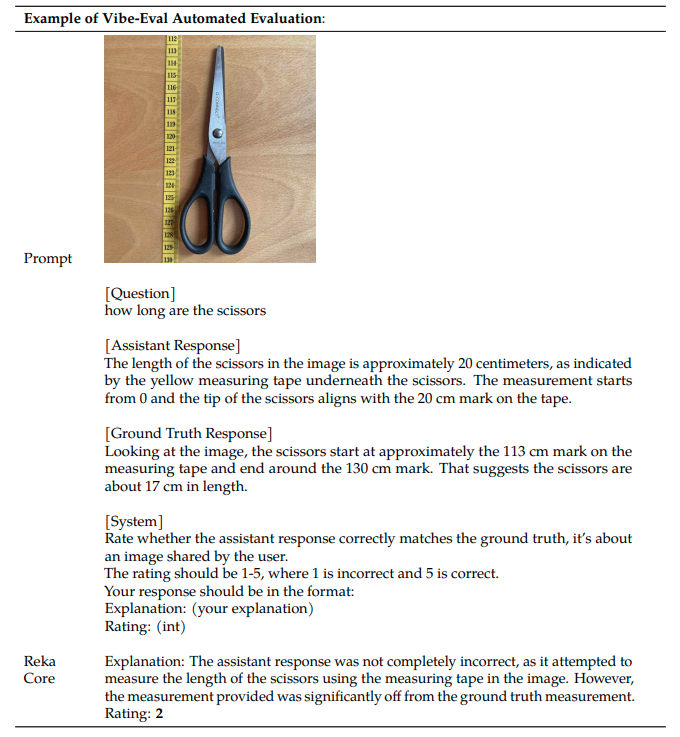

In [ ]:
def format_judge_prompt(question: str, answer: str, groundtruth_answer: str) -> str:
    """Format the judge prompt."""
    system_message = """
        Rate whether the assistant response correctly matches the ground truth, it's about an image
        shared by the user. The rating should be 1-5, where 1 is incorrect and 5 is correct. Your
        response should be in the format:\n
        [Explanation]\n<your explanation>\n[Rating]\n<A single number>\n
    """
    qa = f"[Question]\n{question}\n[Assistant Response]\n{answer}"
    gt = f"[Ground Truth]\n{groundtruth_answer}"
    message = f"{qa}\n{gt}\n{system_message}"
    return message


def parse_response(generated_text: str) -> dict[str, str | int]:
    """Parse the response from the judge."""
    assistant_generated_text = generated_text.split("Assistant:")[-1].strip()
    try:
        rating = int(assistant_generated_text.split("[Rating]")[-1])
    # For some reason the model did not follow the requested format
    except:
        rating = 1

    try:
        explanation = (
            assistant_generated_text.split("[Rating]")[0].split("[Explanation]")[-1].strip()
        )
    # For some reason the model did not follow the requested format
    except:
        explanation = ""

    return {"rating": rating, "explanation": explanation}

Rate the predictions from Part 2

In [ ]:
ratings = []
explanations = []
zipped = zip(range(MAX_EXAMPLES), predictions, strict=True)
for example_idx, prediction in tqdm(zipped, total=MAX_EXAMPLES, desc="Generating Ratings"):
    example = dataset["test"][example_idx]
    message = format_judge_prompt(
        question=example["prompt"],
        answer=prediction,
        groundtruth_answer=example["reference"],
    )

    message = {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": message},
        ],
    }

    image = example["image"]
    prompt = processor.apply_chat_template([message], add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    generated_ids = model.generate(**inputs, max_new_tokens=500, min_new_tokens=50)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    parsed_response = parse_response(generated_text)
    ratings.append(parsed_response["rating"])
    explanations.append(parsed_response["explanation"])

print(ratings)

<a name="section:part4"></a>
# Part 4: Assessing The Ratings of The Judge Model

We have a multimodal chat model (Idefics3) that is being used for general purpose multimodal tasks (asking questions about images, captioning visual content etc). To evaluate this model we used a held-out dataset (VibeEval) with image-prompt pairs covering a wide range of capabilities. We then asked the same model (it could have been a different one) to play the role of a judge and provide a rating for its predictions after having access to exemplary responses. Are we done yet? **No**


We would like to know if the scores provided by the judge are calibrated to the human's judgement. In the sections below you will act as a judge for some predictions of the model, and provide a rating given the input image and the corresponding ground truth response.


---
**Question**


* Is the model-based judge providing similar scores to you?
* If not, is the model under, or overestimating your scores?
* Can you think of any potential issues that might affect the way the judge provides a score?

In [ ]:
import random
import string

GRADIO_URLS = [
    "https://57a4dc6a58d813e921.gradio.live/",
    "https://57a4dc6a58d813e922.gradio.live/",
    "https://57a4dc6a58d813e923.gradio.live/",
    "https://57a4dc6a58d813e924.gradio.live/",
    "https://57a4dc6a58d813e925.gradio.live/",
    "https://57a4dc6a58d813e928.gradio.live/",
    "https://57a4dc6a58d813e929.gradio.live/",
    "https://57a4dc6a58d813e930.gradio.live/",
]


def random_string_generator(num_charas: int) -> str:
    """Generate a random string of fixed length."""
    return "".join(
        random.choice(string.ascii_uppercase + string.digits) for _ in range(num_charas)
    )

def append_metadata_to_url(url: str, metadata: dict) -> str:
    """Append metadata to a URL."""
    if not url.endswith("/"):
        url = f"{url}/"

    metadata_str = "&".join([f"{k}={v}" for k, v in metadata.items()])
    return f"{url}?{metadata_str}"


username = random_string_generator(5)
index = hash(username) % len(GRADIO_URLS)
# Open the URL in the browser
print(append_metadata_to_url(GRADIO_URLS[index], {"USERNAME": username}))

<a name="section:conclusion"></a>
# Conclusion


## Finetuning a Visual Language Model from Hugging Face
You should have the basic tools required to retrieve a pretrained multimodal model from Hugging Face and apply it to your own use-case. Of course there are many other multimodal models available ([LLaVA](https://proceedings.neurips.cc/paper_files/paper/2023/hash/6dcf277ea32ce3288914faf369fe6de0-Abstract-Conference.html), [InstructBLIP](https://arxiv.org/pdf/2305.06500)). Each model employs a different (but in many cases quite similar) training regime, by using a different vision encoder or a language model as a starting point, as well as training on different instructions / demonstrations.


When selecting an off-the-shelf model, it is important to understand these differences as they can impact the performance on your downstream application. Details like the resolution of images can play a crucial role on resolution-demanding tasks like document understanding. Similarly the quality of the language backbone may also affect your finetuned model.


## Concerns with using Models as Judges
It is not straightforward how to evaluate open-ended and free-form generation. In our first part of the lab our model was constrained to a small output space where we could use word overlap metrics to quantify the performance of our model.


However, when the model is allowed to generate more free-form answers things get complicated. Multiple generations of varying length can be equally plausible, meaning that word overlap metrics are not exactly reflecting the model's performance. Using a model-based automatic evaluation we can provide a *proxy* for the model's performance.


Nevertheless, when using a model as a judge it is important to be mindful of its implications:


* What if I change my judge prompt? Variations in the prompt will inevitably result in different ratings from your judge.
* As we already saw, are the scores of my judge-model correlating with human judgements?
* Is greedy decoding a suitable way to generate representative outputs from my model? Do I need to evaluate multiple generations for the same input (using sampling, beam search etc).


The paper [LLMs instead of Human Judges? A Large Scale Empirical Study across 20 NLP Evaluation Tasks](https://arxiv.org/abs/2406.18403), provides an overview regarding the validity of these types of evaluations focusing on NLP tasks though the findings directly translate to multimodal tasks.


<a name="section:acknowledgement"></a>
# Acknowledgements
* [Idefics2 finetuning colab](https://colab.research.google.com/drive/1NtcTgRbSBKN7pYD3Vdx1j9m8pt3fhFDB?usp=sharing)